In [2]:
import pandas as pd
import numpy as np
import os
from bokeh.io import output_notebook, show
output_notebook()
import bokeh as bh
from sklearn.preprocessing import LabelEncoder
from glob import glob
import re
from math import ceil
import xgboost as xgb
from sklearn.model_selection import GroupKFold,KFold
import random
import operator
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
pd.options.display.max_columns = 1000

Loading BokehJS ...

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
os.chdir('C:/Users/pavan.velaga/Downloads')

C:\Users\pavan.velaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
data = pd.read_csv( "CAX_MortgageModeling_Train.csv")
submission_raw = pd.read_csv("CAX_MortgageModeling_Test.csv")

In [5]:
#data.head(10)

In [6]:
data['PROPERTY TYPE'].value_counts()

#High Rise<Townhouse Condominium<Townhouse Freehold<Semi-Detached<Single Detached<Duplex<Triplex<Fourplex
submission_raw['PAYMENT FREQUENCY'].value_counts()

Monthly                  14299
Bi-Weekly                  585
Bi-Weekly Accelerated      326
Weekly Accelerated           2
Semi-Monthly                 1
Weekly                       1
Name: PAYMENT FREQUENCY, dtype: int64

In [7]:

def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ( 'Day', 'Dayofweek', 'Month',
              'Is_month_end', 'Is_month_start'):
        df[targ_pre+n] = getattr(fld.dt, n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9

In [8]:
def feature_creation(df):
    
    df['appriesed_property_value'] = df['MORTGAGE AMOUNT']/df['LTV']
    
    df['property_apprl'] = df['appriesed_property_value']/df['PROPERTY VALUE']
    #df['repayment_rate'] = 
    df['n_years'] = df['AMORTIZATION']/12
    df['anl_income'] = df['INCOME']/df['n_years']
    df['anl_housing_exp'] = df['anl_income'] * df['GDS']
    df['other_expenses'] = (df['anl_income']*df['TDS']) - df['anl_housing_exp']
    df['rate_property_apprl_yr'] = df['property_apprl']/df['n_years']
    df['rate_property_apprl_trm'] = df['property_apprl']/df['TERM']
    df['rate_property_apprl_amr'] = df['property_apprl']/df['AMORTIZATION']
    df['dipo_income'] = df['anl_income'] - df['other_expenses'] - df['anl_housing_exp']
    df['value_ratio'] = df['PROPERTY VALUE']/df['MORTGAGE AMOUNT']
    df['inc_mrg_rto'] = df['INCOME']/df['MORTGAGE AMOUNT']
    df['dinc_mrg_rt'] = df['dipo_income']/df['MORTGAGE AMOUNT']
    df['inc_py'] = df['INCOME']/df['n_years']
    df['pt'] = df['PROPERTY TYPE'].map({'High Rise':4,'Townhouse Condominium':1
                                        ,'Townhouse Freehold':2,'Semi-Detached':3
                                       ,'Single Detached':5,'Duplex':6
                                       ,'Triplex':7,'Fourplex':8})
        
    df['new_pyt_frq'] = df['PAYMENT FREQUENCY'].map({'Weekly Accelerated':1,'Weekly':2
                                        ,'Bi-Weekly Accelerated':3,'Bi-Weekly':4
                                       ,'Semi-Monthly':5,'Monthly':6})
    
    return(df)

In [9]:
data = feature_creation(data)
submission_raw = feature_creation(submission_raw)

In [10]:
data.head(5)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,target,appriesed_property_value,property_apprl,n_years,anl_income,anl_housing_exp,other_expenses,rate_property_apprl_yr,rate_property_apprl_trm,rate_property_apprl_amr,dipo_income,value_ratio,inc_mrg_rto,dinc_mrg_rt,inc_py,pt,new_pyt_frq
0,CAX_Train_301,301,3525000,15033,7.96,80.0,23.90,360,2820000.0,5.00,Purchase,Monthly,Single Detached,12,M5P,70 and over,Male,3860000,8,23,671,NOT FUNDED,1,35250.000000,0.010000,30.0,128666.666667,1.024187e+06,2.050947e+06,0.000333,0.000833,0.000028,-2.946467e+06,1.250000,1.368794,-1.044846,128666.666667,5,6
1,CAX_Train_15869,15869,3525000,13922,8.75,65.0,28.01,360,2820000.0,5.25,Purchase,Monthly,Single Detached,12,M5P,70 and over,Male,3860000,8,23,692,FUNDED,0,43384.615385,0.012308,30.0,128666.666667,1.125833e+06,2.478120e+06,0.000410,0.001026,0.000034,-3.475287e+06,1.250000,1.368794,-1.232371,128666.666667,5,6
2,CAX_Train_40049,40049,2600000,9709,6.88,65.0,30.69,360,1690000.0,4.75,Refinance,Monthly,Single Detached,12,M4R,30-34,Unknown,3430000,8,23,755,FUNDED,0,26000.000000,0.010000,30.0,114333.333333,7.866133e+05,2.722277e+06,0.000333,0.000833,0.000028,-3.394557e+06,1.538462,2.029586,-2.008613,114333.333333,5,6
3,CAX_Train_29403,29403,4300000,22149,7.12,75.0,17.06,300,3225000.0,5.75,Purchase,Monthly,High Rise,12,M4W,60-64,Male,2441000,8,53,823,NOT FUNDED,1,43000.000000,0.010000,25.0,97640.000000,6.951968e+05,9.705416e+05,0.000400,0.000833,0.000033,-1.568098e+06,1.333333,0.756899,-0.486232,97640.000000,4,6
4,CAX_Train_4672,4672,900000,3960,3.38,75.0,9.79,360,675000.0,5.00,Purchase,Monthly,Single Detached,12,L3P,45-49,Male,2400000,8,23,734,FUNDED,0,9000.000000,0.010000,30.0,80000.000000,2.704000e+05,5.128000e+05,0.000333,0.000833,0.000028,-7.032000e+05,1.333333,3.555556,-1.041778,80000.000000,5,6


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
data.columns


Index(['Unique_ID', 'MORTGAGE NUMBER', 'PROPERTY VALUE', 'MORTGAGE PAYMENT',
       'GDS', 'LTV', 'TDS', 'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE',
       'MORTGAGE PURPOSE', 'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'FSA',
       'AGE RANGE', 'GENDER', 'INCOME', 'INCOME TYPE', 'NAICS CODE',
       'CREDIT SCORE', 'RESULT', 'target', 'appriesed_property_value',
       'property_apprl', 'n_years', 'anl_income', 'anl_housing_exp',
       'other_expenses', 'rate_property_apprl_yr', 'rate_property_apprl_trm',
       'rate_property_apprl_amr', 'dipo_income', 'value_ratio', 'inc_mrg_rto',
       'dinc_mrg_rt', 'inc_py', 'pt', 'new_pyt_frq'],
      dtype='object')

In [13]:
features = ['PROPERTY VALUE', 
            'MORTGAGE PAYMENT',
       'GDS', 'LTV', 'TDS', 'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE','PROPERTY TYPE',
       'MORTGAGE PURPOSE', 'TERM', 'FSA',
       'AGE RANGE', 'GENDER', 'INCOME', 'INCOME TYPE', 'NAICS CODE','anl_housing_exp','appriesed_property_value','PAYMENT FREQUENCY'
            ,'property_apprl','dipo_income','value_ratio','inc_mrg_rto','pt','inc_py','dinc_mrg_rt','anl_income','new_pyt_frq']
target = ['target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.25, random_state=99)

In [15]:
for f in features:
    if X_train[f].dtype=='object':
        print(f+"-"+str(X_train[f].dtype))
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values) + list(submission_raw[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))
        submission_raw[f] = lbl.transform(list(submission_raw[f].values))

PROPERTY TYPE-object
MORTGAGE PURPOSE-object
FSA-object
AGE RANGE-object
GENDER-object
NAICS CODE-object
PAYMENT FREQUENCY-object


In [16]:
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features],label=y_test)



In [17]:
#num_rounds = 130
xgb_preds_lst = []
models = []
for i in ([0,199,10999]):
    watchlist = [(dtrain, 'train'), (dtest, 'val')]
    params = {'objective': 'binary:logistic',
              'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': 4,
              'max_depth': 5,
              'subsample': 0.8,
              'min_child_weight': 1,
              "colsample_bytree": 0.9,
              'eta': 0.05,
              'verbose_eval': True,
              'silent':1,
              'seed': i
              }

    clf_xgb = xgb.train(params, dtrain, num_boost_round=2000, verbose_eval=200, early_stopping_rounds=30, evals=watchlist)
    xgb_preds_lst.append(clf_xgb.predict(dtest))  
    
    models.append(clf_xgb)

[0]	train-auc:0.67036	val-auc:0.674336
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.801202	val-auc:0.741205
[400]	train-auc:0.847371	val-auc:0.748453
[600]	train-auc:0.884373	val-auc:0.753165
Stopping. Best iteration:
[645]	train-auc:0.892102	val-auc:0.754054

[0]	train-auc:0.647576	val-auc:0.644206
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.803226	val-auc:0.742696
[400]	train-auc:0.856899	val-auc:0.749905
[600]	train-auc:0.891263	val-auc:0.752807
Stopping. Best iteration:
[583]	train-auc:0.888755	val-auc:0.753057

[0]	train-auc:0.673169	val-auc:0.674928
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.802799	val-auc:0.741167
[400]	train-auc:0.855943	val-auc

In [18]:
val_preds= [(xgb_preds_lst[0][i]+xgb_preds_lst[1][i]+xgb_preds_lst[2][i])/3 for i in range(len(xgb_preds_lst[1]))]


In [19]:
watchlist = [(dtrain, 'train'), (dtest, 'val')]
params = {'objective': 'binary:logistic',
              'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': 4,
              'max_depth': 5,
              'subsample': 0.8,
              'min_child_weight': 1,
              "colsample_bytree": 0.9,
              'eta': 0.05,
              'verbose_eval': True,
              'silent':1,
              'seed': 99
              }

clf_xgb = xgb.train(params, dtrain, num_boost_round=2000, verbose_eval=200, early_stopping_rounds=30, evals=watchlist)

[0]	train-auc:0.669373	val-auc:0.673605
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.799839	val-auc:0.742079
[400]	train-auc:0.851477	val-auc:0.74992
[600]	train-auc:0.88707	val-auc:0.753289
Stopping. Best iteration:
[595]	train-auc:0.886191	val-auc:0.753358



In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf_xgb,max_num_features=50, height=0.8, ax=ax)
plt.show()


<Figure size 1200x1800 with 1 Axes>

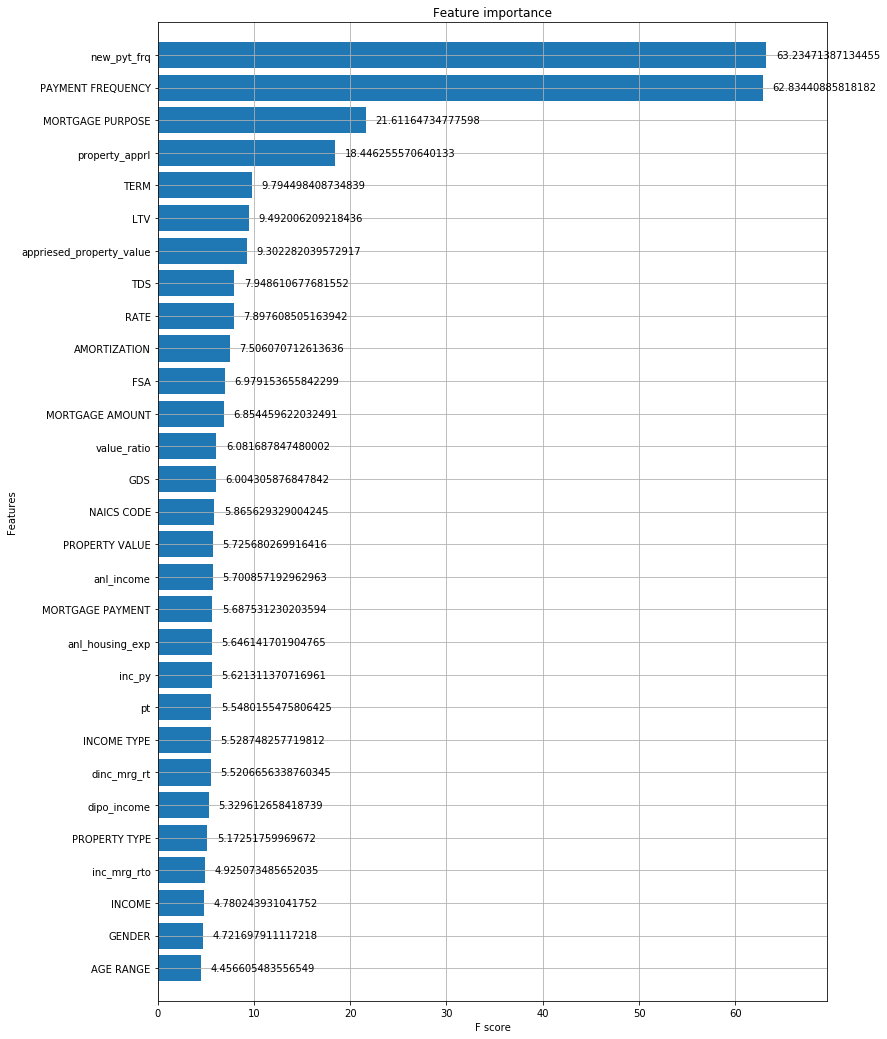

In [21]:

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf_xgb,importance_type= "gain", max_num_features=50, height=0.8, ax=ax)
plt.show()


In [22]:
importance = clf_xgb.get_score(importance_type='gain')
importance_df = pd.DataFrame(
    sorted(importance.items(), key=operator.itemgetter(1)), 
    columns=['feature','gain']
    )

In [23]:
class MetricsMeter():    
    def __init__(self, y_true, y_pred, threshold):
        self.y_true = y_true        
        self.y_pred = y_pred        
        self.thresh = threshold            
    
    def fit(self):        
        metrics = {}        
        metrics['auc'] = roc_auc_score(self.y_true, self.y_pred)                
        self.y_pred = [1 if x > self.thresh else 0 for x in self.y_pred]        
        metrics['f1'] = f1_score(self.y_true, self.y_pred,average = 'macro')        
        tn, fp, fn, tp = confusion_matrix(self.y_true, self.y_pred).ravel()                
        metrics['sensitivity/recall'] = tp / (tp+fn)
        metrics['precision'] = tp / (tp+fp)
        metrics["accuracy"] = (tp + tn) / (tp + fp + fn + tn)
        metrics['specificity'] = tn / (tn+fp)
        return metrics

In [24]:
val_preds = clf_xgb.predict(dtest)

In [25]:

dr_metrics = MetricsMeter(y_test, val_preds, i)
scores = dr_metrics.fit()    
scores['thresh'] = i    

C:\Users\pavan.velaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pavan.velaga\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  


In [26]:
m = [] 
for i in np.linspace(0.01, 0.99, num=90):    
    dr_metrics = MetricsMeter(y_test, val_preds, i)
    scores = dr_metrics.fit()    
    scores['thresh'] = i    
    m.append(scores) 
m_build = pd.DataFrame(m)


# 

In [27]:
a = m_build.sort_values('f1', ascending=False)

In [28]:
a.head(10) #0.635282 #0.658185 #0.662413 #0.662483 ------ #0.658630 #0.661719  #0.662847 -- #0.666183

,accuracy,auc,f1,precision,sensitivity/recall,specificity,thresh
28,0.783630,0.752892,0.662398,0.488621,0.434711,0.877544,0.318315
24,0.760319,0.752892,0.661927,0.444444,0.520661,0.824825,0.274270
27,0.776794,0.752892,0.660212,0.472475,0.450413,0.864642,0.307303
23,0.751906,0.752892,0.659947,0.432777,0.546694,0.807140,0.263258
26,0.770572,0.752892,0.659919,0.460113,0.471901,0.850962,0.296292
29,0.788099,0.752892,0.659481,0.500506,0.409091,0.890112,0.329326
25,0.763824,0.752892,0.658554,0.448211,0.491736,0.837059,0.285281
22,0.743230,0.752892,0.657099,0.422066,0.570661,0.789679,0.252247
30,0.791692,0.752892,0.656794,0.511704,0.388430,0.900234,0.340337
31,0.794935,0.752892,0.655153,0.523175,0.373140,0.908464,0.351348


In [30]:
dsub = xgb.DMatrix(submission_raw[features])
predictions = []
submission_raw['probs'] = clf_xgb.predict(dsub)

In [31]:
submission_raw['Result_Predicted'] = np.where(submission_raw['probs']>0.318315,'NOT FUNDED','FUNDED')

In [32]:
inter_data = pd.concat([X_test,y_test],axis = 1) 
inter_data['preds'] = val_preds
 #inter_data = pd.concat([inter_data,np.array(val_preds)],axis = 1)

In [33]:
final_sub = submission_raw[['Unique_ID','Result_Predicted']]

In [34]:
final_sub['Result_Predicted'].value_counts()

FUNDED        12503
NOT FUNDED     2711
Name: Result_Predicted, dtype: int64

In [35]:
final_sub.to_csv('new_ft_sub21v.csv',index=False)

In [ ]:
#inter_data.to_csv('inter_data_probs.csv',index=False)

In [ ]:
#inter_data

In [ ]:
submission_raw.head(10)